In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pymc3 as pm

In [4]:
import numpy as np
import corner
import emcee
import scipy.optimize as op
from astropy.constants import c
from astropy import units as units


u, v, delay, sigma = np.loadtxt('data_45.txt',usecols=(1,2,3,4),unpack=True)
radtomas = (1 * units.rad).to(units.mas).value
dec = - (14 * units.deg + 58 * units.arcmin).to (units.rad).value

# suppose ant 1 is the ref antenna, calculate the uv coordinates
u = u - u[0]
v = v - v[0]

# u = u[1:]
# v = v[1:]
# delay = delay[1:]
# sigma = sigma[1:]

# get u,v in the units of s, delay in the units of s*mas
u = u/c.value
v = v/c.value
delay = delay*radtomas*((1*units.ns).to(units.s).value)
sigma = sigma*radtomas*((1*units.ns).to(units.s).value)
sigma_avg = np.mean(sigma)

In [8]:
delay

array([ 0.        , -3.15585154, -4.02628902, -5.77953987])

In [7]:
(sigma)

array([0.        , 0.34301837, 0.85249244, 0.43171224])

In [13]:
sigma[0] = 0.10

(-0.005, 0.005)

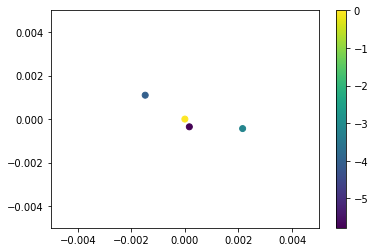

In [35]:
plt.scatter(u,v,c=delay)
plt.colorbar()
plt.xlim([-0.005,0.005])
plt.ylim([-0.005,0.005])

In [36]:
with pm.Model() as pymc3_model:
    delta_alpha_mas = pm.Uniform("delta_alpha_mas", lower=-5000, upper=5000)
    delta_delta_mas = pm.Uniform("delta_delta_mas", lower=-5000, upper=5000)
    equad = pm.Uniform("equad", lower=0.01, upper=0.4)
    model = delta_alpha_mas * u * np.cos(dec) + delta_delta_mas * v
    pm.Normal("loglike", mu=model, sd=np.sqrt(sigma**2+equad**2), observed=delay)

In [41]:
with pymc3_model:
    trace = pm.sample(tune=20000, draws=10000, chains=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 4 jobs)
NUTS: [equad, delta_delta_mas, delta_alpha_mas]
Sampling 16 chains: 100%|██████████| 480000/480000 [03:40<00:00, 2174.12draws/s]
The acceptance probability does not match the target. It is 0.8787433093172408, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6680099191447058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6492254679232728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6898462132609231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827589666444691, but should be close to 0.8. Try to increase the number of tunin

In [42]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
delta_alpha_mas,-1046.430411,379.647458,1.272889,-1785.708202,-297.474798,69006.206967,1.000046
delta_delta_mas,219.612007,1042.785703,3.716862,-1797.993831,2286.178805,67797.663009,1.000067
equad,0.391853,0.008117,0.000023,0.375605,0.400000,121853.007166,0.999984


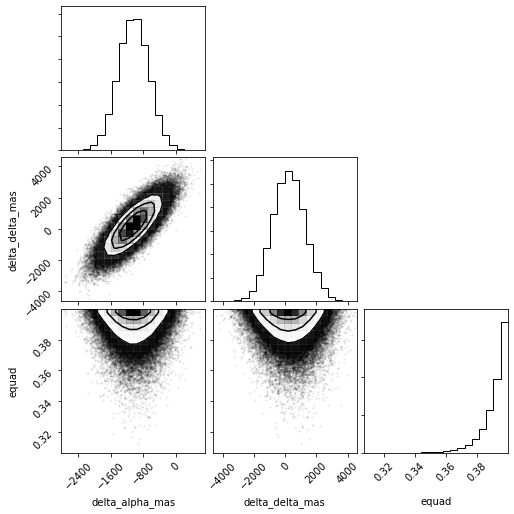

In [43]:
pymc3_samples = pm.trace_to_dataframe(trace, varnames=["delta_alpha_mas", "delta_delta_mas", "equad"])
corner.corner(pymc3_samples);

In [40]:
pymc3_samples.shape

(160000, 3)